In [1]:
!pip3 install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=9f41f83afa826f9bea263a6700b3094ee3dc915360071068744b733a4f947ab7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3e190b23c0cd4a07d1987ca288daf

In [2]:
!pip3 install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rz1lsa5e
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rz1lsa5e
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=13ecbe5a2af5acdd2345c3e29a4c1d701978606a162a1f55059527f1f3a64c49
  Stored in directory: /tmp/pip-ephem-wheel-cache-mu0npmfc/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [3]:
device = 'cuda'
device

'cuda'

In [4]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [5]:
!ls


Road_seg_dataset/  sample_data/


In [6]:
!cd Road_seg_dataset

/content/Road_seg_dataset


In [7]:
!pwd

'/content/Road_seg_dataset'

In [8]:
import sys
sys.path.append('Road_seg_dataset')

In [9]:
import cv2
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import helper

In [10]:
df = pd.read_csv('train.csv')
Epochs = 25
lr = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [11]:
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


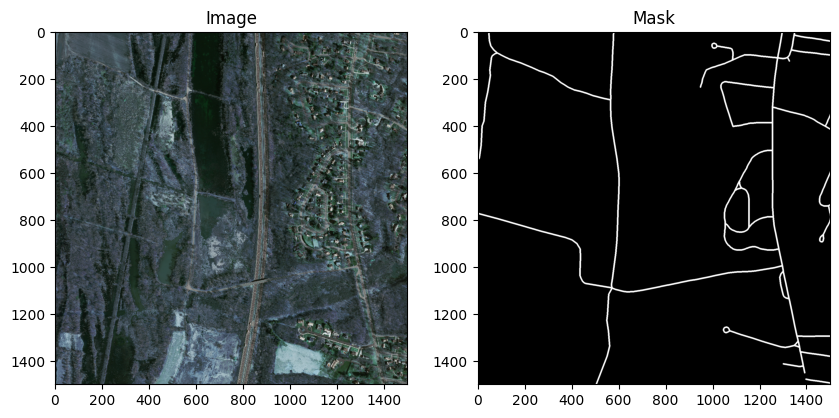

In [12]:
idx =15
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Image')
ax1.imshow(cv2.imread(df.iloc[idx]['images'])/255)
ax2.set_title('Mask')
ax2.imshow(cv2.imread(df.iloc[idx]['masks'])/255)

In [13]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=0.2)

In [14]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

# Augmentation Function

In [15]:
import albumentations as A


In [16]:
def get_train_augs():
    return T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
            T.Resize(IMG_SIZE),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p = 0.5)
        ])
def get_valid_augs():
    return T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
            T.Resize(IMG_SIZE)
        ])

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms as T

In [18]:
class SegmenataionDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fpaths = self.df.iloc[idx]
        image = cv2.imread(fpaths['images'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(fpaths['masks'], cv2.IMREAD_GRAYSCALE)
#         mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            image = self.augmentations()(image)
            mask = self.augmentations()(mask)

        return image, mask

In [19]:
trainset = SegmenataionDataset(train_df, get_train_augs)
validset = SegmenataionDataset(valid_df, get_valid_augs)

In [20]:
image, mask = trainset[3]
image

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[0.3386, 0.1954, 0.3363,  ..., 0.2007, 0.1688, 0.6701],
         [0.4480, 0.3999, 0.2812,  ..., 0.1116, 0.0804, 0.2207],
         [0.4070, 0.2679, 0.1780,  ..., 0.3177, 0.3261, 0.1393],
         ...,
         [0.1357, 0.2137, 0.3078,  ..., 0.7309, 0.6338, 0.6083],
         [0.2495, 0.3623, 0.4697,  ..., 0.7127, 0.6711, 0.6564],
         [0.2762, 0.4796, 0.2040,  ..., 0.6610, 0.6259, 0.6291]],

        [[0.4188, 0.2733, 0.3756,  ..., 0.3367, 0.3208, 0.6239],
         [0.5074, 0.4497, 0.3541,  ..., 0.1332, 0.1447, 0.3937],
         [0.5039, 0.3516, 0.2206,  ..., 0.2760, 0.2805, 0.1994],
         ...,
         [0.1376, 0.2621, 0.3248,  ..., 0.7324, 0.6535, 0.6487],
         [0.2148, 0.3351, 0.4037,  ..., 0.7271, 0.6904, 0.6786],
         [0.2443, 0.4215, 0.1980,  ..., 0.6905, 0.6542, 0.6518]],

        [[0.2657, 0.1553, 0.2720,  ..., 0.1729, 0.1661, 0.5469],
         [0.3881, 0.3116, 0.1998,  ..., 0.0853, 0.0481, 0.1909],
         [0.3450, 0.2177, 0.1307,  ..., 0.2017, 0.2218, 0.

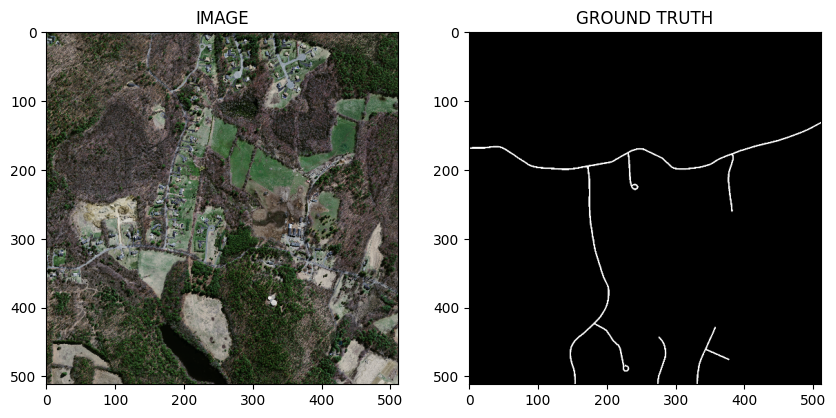

In [21]:
helper.show_image(image, mask)

In [22]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)


In [23]:
len(trainloader), len(validloader)

(20, 5)

In [24]:
for images, mask in trainloader:
    print(images.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])
torch.Size([7, 3, 512, 512])


In [25]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [26]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
        encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self, images, masks=None):
        logits = self.backbone(images)
        if masks !=None:
            return logits, (DiceLoss(mode='binary')(logits, masks)+nn.BCEWithLogitsLoss()(logits, masks))
        return logits

In [27]:
model = SegmentationModel()
model.to(device);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 19.1MB/s]


In [28]:
def train_fn(dataloader, model, optimizer):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss +=loss.item()
    return total_loss / len(dataloader)


In [29]:
def eval_fn(dataloader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            logits, loss = model(images, masks)
            total_loss +=loss.item()
        return total_loss / len(dataloader)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_loss = np.Inf
for i in range(Epochs):
    train_loss=train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    if valid_loss < best_loss:
        torch.save(model.state_dict(), f'best-: {i} model.pt')
        print("Saved Model")
        best_loss = valid_loss
    print(f"EPOCH {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Saved Model
EPOCH 1 Train Loss: 1.2060679912567138 Valid Loss: 1.2850549221038818


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Saved Model
EPOCH 2 Train Loss: 1.1144797801971436 Valid Loss: 1.033681583404541


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Saved Model
EPOCH 3 Train Loss: 1.0837732613086701 Valid Loss: 0.9701748132705689


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Saved Model
EPOCH 4 Train Loss: 1.0888162046670913 Valid Loss: 0.9253425002098083


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Saved Model
EPOCH 5 Train Loss: 1.0924400836229324 Valid Loss: 0.8998945593833924


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Saved Model
EPOCH 6 Train Loss: 1.0707980006933213 Valid Loss: 0.8846919059753418


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH 7 Train Loss: 1.100588384270668 Valid Loss: 0.9401430010795593


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Saved Model
EPOCH 8 Train Loss: 1.0702743053436279 Valid Loss: 0.8790784001350402


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Saved Model
EPOCH 9 Train Loss: 1.0494983345270157 Valid Loss: 0.8526856660842895


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Saved Model
EPOCH 10 Train Loss: 1.0686343967914582 Valid Loss: 0.8239355206489563


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


EPOCH 11 Train Loss: 1.0564228117465972 Valid Loss: 0.8286826848983765


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Saved Model
EPOCH 12 Train Loss: 1.0611272275447845 Valid Loss: 0.8230771422386169


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


EPOCH 13 Train Loss: 1.06180040538311 Valid Loss: 0.8474129915237427


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


EPOCH 14 Train Loss: 1.08024560213089 Valid Loss: 0.8345924019813538


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH 15 Train Loss: 1.0546200782060624 Valid Loss: 0.8475506544113159


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


EPOCH 16 Train Loss: 1.0673045694828034 Valid Loss: 0.8359732508659363


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Saved Model
EPOCH 17 Train Loss: 1.072210857272148 Valid Loss: 0.8046421885490418


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


EPOCH 18 Train Loss: 1.0623493820428849 Valid Loss: 0.8465288162231446


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


EPOCH 19 Train Loss: 1.0831951200962067 Valid Loss: 0.8211211919784546


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


EPOCH 20 Train Loss: 1.0855197459459305 Valid Loss: 0.8655679583549499


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Saved Model
EPOCH 21 Train Loss: 1.055881068110466 Valid Loss: 0.7910560727119446


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


EPOCH 22 Train Loss: 1.0677389532327652 Valid Loss: 0.8210830569267273


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH 23 Train Loss: 1.0777561664581299 Valid Loss: 0.8216429829597474


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Saved Model
EPOCH 24 Train Loss: 1.0264865547418593 Valid Loss: 0.7493852257728577


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

EPOCH 25 Train Loss: 1.0354215860366822 Valid Loss: 0.7630258440971375


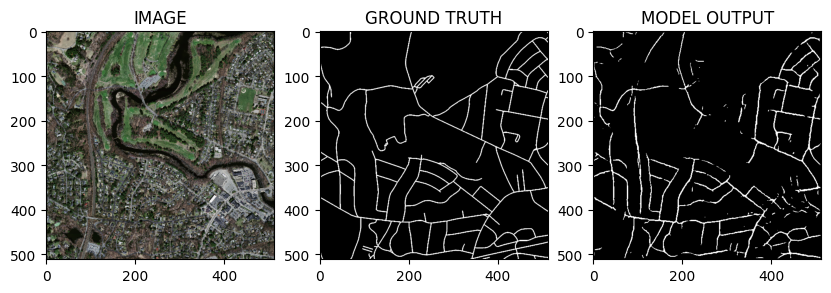

In [39]:
model.load_state_dict(torch.load('/content/Road_seg_dataset/best-: {}model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask =(pred_mask > 0.5)*1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))